# Gaussian process in a fully Bayesian mode

This notebook demonstrates an application of the Gaussian process class in GPax package to a 1D problem.

*Prepared by Maxim Ziatdinov (2024)*

Edited by Josiah Park for the present purposes (2024)

Gaussian process (GP) is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space from sparse measurements. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP aims to reconstruct the function $f(x)$ such as $y_i= f(x_i) + 𝜀_i$, with $f$ sampled from a multivariate normal prior distribution, $f ∼ MVN(0; K(x_i, x_j))$. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference.

## Install & Import

Install GPax package:

In [1]:
!pip install -q gpax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.1/351.1 kB 6.0 MB/s eta 0:00:00


In [51]:
!pip3 install openmeteo-requests
!pip3 install requests-cache retry-requests numpy pandas
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 37.8715,
	"longitude": 122.273,
	"current": "surface_pressure",
	"hourly": "surface_pressure",
	"start_date": "2024-07-22",
	"end_date": "2024-10-14"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Current values. The order of variables needs to be the same as requested.
current = response.Current()
current_surface_pressure = current.Variables(0).Value()

print(f"Current time {current.Time()}")
print(f"Current surface_pressure {current_surface_pressure}")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_surface_pressure = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)
hourly_dataframe.shape


Coordinates 37.875°N 122.25°E
Elevation 0.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Current time 1728955800
Current surface_pressure 1019.2000122070312
                          date  surface_pressure
0    2024-07-22 00:00:00+00:00       1001.200012
1    2024-07-22 01:00:00+00:00       1001.400024
2    2024-07-22 02:00:00+00:00       1000.599976
3    2024-07-22 03:00:00+00:00       1000.000000
4    2024-07-22 04:00:00+00:00        999.599976
...                        ...               ...
2035 2024-10-14 19:00:00+00:00       1016.099976
2036 2024-10-14 20:00:00+00:00       1016.099976
2037 2024-10-14 21:00:00+00:00       1016.400024
2038 2024-10-14 22:00:00+00:00       1017.000000
2039 2024-10-14 23:00:00+00:00       1018.000000

[2040 rows x 2 columns]


(2040, 2)

Import needed packages:

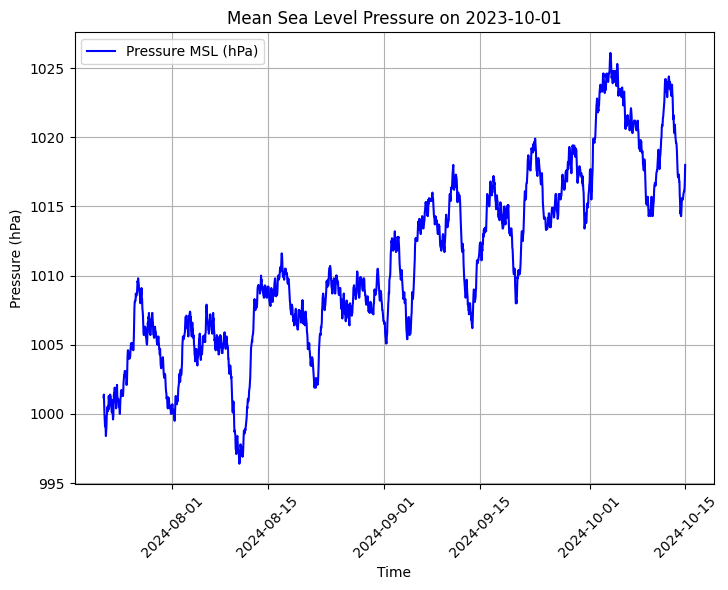

In [52]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(14, 6))

# Plotting Mean Sea Level Pressure
plt.subplot(1, 2, 1)
plt.plot(hourly_dataframe['date'], hourly_dataframe['surface_pressure'], color='blue', label='Pressure MSL (hPa)')
plt.title('Mean Sea Level Pressure on 2023-10-01')
plt.xlabel('Time')
plt.ylabel('Pressure (hPa)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()


# Adjust layout
plt.tight_layout()
plt.show()

In [53]:
import numpy as np
NOISE_LEVEL = 1.0   # Example noise level
NUM_INIT_POINTS = 2040  # Example number of initial points

# Generate random samples from a normal distribution
random_values = np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Create a Pandas DataFrame
df = pd.DataFrame(random_values, columns=['surface_pressure'])
x1=pd.DataFrame(hourly_dataframe['date'])
y=pd.DataFrame(hourly_dataframe['surface_pressure'])
yy=df+y

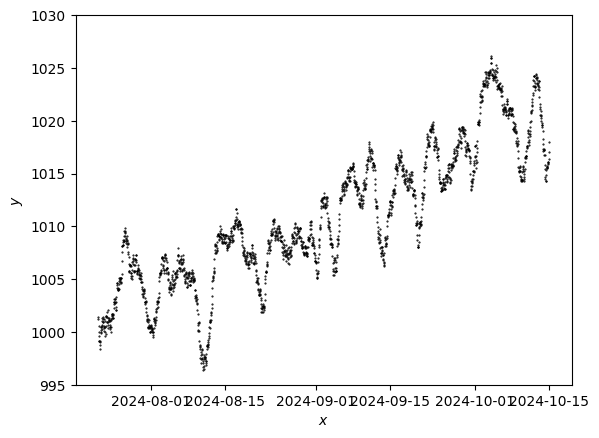

In [54]:
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(x1, y, marker='o', c='k', zorder=1,  s=.25,  label='No noise')
plt.ylim(995, 1030);

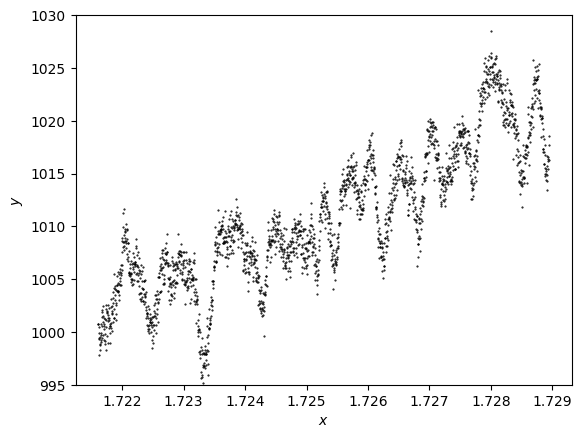

In [111]:
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(x1, yy, marker='o', c='k', zorder=1,  s=.25,  label='Noisy observations')
plt.ylim(995, 1030);

In [56]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

In [57]:
yy=yy.to_numpy()

In [66]:
x1 = pd.DataFrame(hourly_dataframe['date'])
x1['unix_time'] = hourly_dataframe['date'].astype('int64') // 10**9  # Convert to seconds
x1['unix_time'] = x1['unix_time'] / 10**9

In [67]:
x1=x1.to_numpy()

In [70]:
x1=x1[:,1]

In [77]:
xx1=jnp.array(x1.astype(np.float32))

In [79]:
print(xx1)

[1.7216064 1.72161   1.7216136 ... 1.7289397 1.7289432 1.7289468]


### Standard GP

Next, we initialize and train a GP model. We are going to use an RBF kernel, $k_{RBF}=𝜎exp(-\frac{||x_i-x_j||^2}{2l^2})$, which is a "go-to" kernel functions in GP.

In [119]:
import jax.numpy as jnp
# Get random number generator keys for training and prediction
key1, key2 = gpax.utils.get_keys()


gp_model.fit(key1, jnp.array(xx1[::2]), jnp.array(y[::2]), num_chains=1, num_warmup=50, num_samples=50)


sample: 100%|██████████| 100/100 [12:14<00:00,  7.35s/it, 11 steps of size 6.33e-03. acc. prob=0.77]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.00      0.00      0.00      0.00      0.00     25.43      0.98
    k_scale 232712.30  36799.36 224833.50 185783.50 299202.62     26.14      0.99
      noise      0.39      0.02      0.39      0.36      0.41     24.17      1.00



"Now let's use our trained model to obtain a probabilistic prediction of function values on new ("test") data. In the fully Bayesian mode, we get a pair of predictive mean and covariance, $𝜇_*^i$ and $𝛴^i_*$, for each *i*-th HMC sample with kernel parameters $𝜃$,

$$𝜇_*^i=K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}y$$
$$𝛴^i_*=K(X_*,X_*|𝜃^i)-K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}K(X,X_*|𝜃^i)$$

The ```.predict()``` method returns the center of the mass of all the predictive means,

$$𝜇^{post}_*= \frac{1}{L} ∑_{i=1}^L 𝜇_*^i,$$

which corresponds to the ```posterior_mean``` in the code cell below, and
samples

$$f_*^i∼MVNormal(𝜇^i_*, 𝛴^i_*)$$

from multivariate normal distributions for all the pairs of predictive means and covariances (```f_samples``` in the code cell below). Note that model noise is absorbed into the kernel computation function."

In [126]:
# Prepare test inputs
X_test = np.linspace(1.71, 1.75, 100)
# Get the GP prediction. Here n stands for the number of samples from each MVNormal distribution
# (the total number of MVNormal distributions is equal to the number of HMC samples)
posterior_mean, f_samples = gp_model.predict(key2, X_test, n=200)

Plot the obtained results:

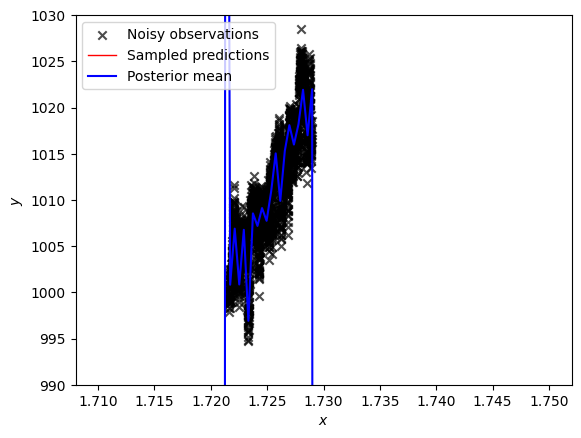

In [127]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(jnp.array(xx1), jnp.array(yy), marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(990, 1030);

We can see there is a relatively large uncertainty - defined by the dispersion in sampled predictions - in GP prediction. It is also common in the GP literature to draw the GP uncertainty as a $2\sigma$ shaded region around the GP posterior mean:

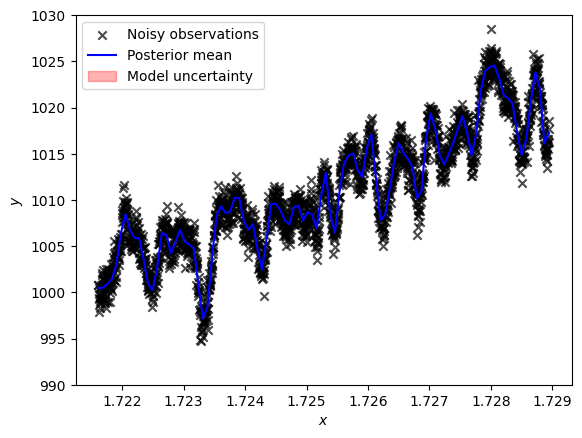

In [122]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(jnp.array(xx1), jnp.array(yy), marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, posterior_mean, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test,
                posterior_mean - f_samples.std(axis=(0,1)),
                posterior_mean + f_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='upper left')
ax.set_ylim(990, 1030);

In [118]:
f_samples

Array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [123]:
gp_model